## Atividade 5 - 17/09/2019

### Aluno: Adriana Bezerra Bessa - C99950 

In [11]:
import math
from math import sqrt
import random
import numpy as np
import pandas as pd
from numpy import array
from keras.models import Sequential
from sklearn.preprocessing import StandardScaler
from keras.layers import Dense
from keras.layers import LSTM
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from scipy.stats import boxcox
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from numpy import array
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from sklearn.metrics import mean_squared_error
from math import log
from math import exp
from sklearn.preprocessing import MinMaxScaler
from numpy import array
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.diagnostic import het_white
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols
%matplotlib inline

plt.style.use('seaborn-whitegrid') # tema para os plots


In [12]:
# Realiza diferenciação
def diferenca(data, lag):
    return [data[i] - data[i - lag] for i in range(lag, len(data))]
# inverte diferenciação
def inverte_diferenca(orig_data, diff_data, lag):
    return [diff_data[i-lag] + orig_data[i-lag] for i in range(lag, len(orig_data))]

def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

def mlp(data,n_steps):
    # separa a sequencia em entrada e saída
    raw_seq=data
    n_steps=n_steps

    X, y = split_sequence(raw_seq, n_steps)

    print(X.shape, y.shape)
    # separa a sequencia em entrada e saída
    X, y = split_sequence(raw_seq, n_steps)

    # define o modelo da rede
    mlp_model = Sequential()

    #mlp_model.add(Dense(100, activation='relu', input_dim=n_steps))
    mlp_model.add(Dense(100, activation='linear', input_dim=n_steps))
    mlp_model.add(Dense(1))
    mlp_model.compile(optimizer='adam', loss='mse')
    history_mlp = mlp_model.fit(X, y, epochs=2000, verbose=0,validation_split=0.1,shuffle = False)
    return mlp_model

def cnn(data,n_steps,n_features):
    raw_seq=data
    n_steps=n_steps
    n_features=n_features
    # divide as amostras
    X, y = split_sequence(raw_seq, n_steps)

    # reformata de [samples, timesteps] para o formato do Conv1D do Keras [samples, timesteps, features]

    X = X.reshape((X.shape[0], X.shape[1], n_features))

    # define model
    cnn_model = Sequential()
    cnn_model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps, n_features)))
    cnn_model.add(MaxPooling1D(pool_size=2))
    cnn_model.add(Flatten())
    cnn_model.add(Dense(100, activation='relu'))
    cnn_model.add(Dense(1))
    cnn_model.compile(optimizer='adam', loss='mse')
    history_cnn = cnn_model.fit(X, y, epochs=100, verbose=0,validation_split=0.1,shuffle = False)
    return cnn_model

def lstm(data,n_steps,n_features):
    raw_seq=data
    n_steps=n_steps
    n_features=n_features
    # split into samples
    X, y = split_sequence(raw_seq, n_steps)

    # reshape from [samples, timesteps] into [samples, timesteps, features]
    #n_features = 1
    X = X.reshape((X.shape[0], X.shape[1], n_features))

    # define model
    lstm_model = Sequential()
    lstm_model.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features)))
    lstm_model.add(Dense(1))
    lstm_model.compile(optimizer='adam', loss='mse')

    # fit model
    history_lstm = lstm_model.fit(X, y, epochs=200, verbose=0,validation_split=0.1,shuffle = False)
    return lstm_model

## Importação dos Dados

In [13]:
df = pd.read_csv('PRECO_PETRO.csv',header=0,delimiter=";",index_col=0)  

PRECO_real = df["Close"]
PRECO_real[0:10]

03/01/2000    4.59375
04/01/2000    4.33594
05/01/2000    4.39453
06/01/2000    4.35938
07/01/2000    4.39453
10/01/2000    4.52344
11/01/2000    4.37109
12/01/2000    4.21875
13/01/2000    4.21875
14/01/2000    4.25391
Name: Close, dtype: float64

# Análise dos Dados

In [14]:
#Verificando estacionariedade, dado que é altamente recomendado o uso de séries estacionárias:
data = df['Close'].values
#data=pd.Series(data)
result = adfuller(data)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.011811
p-value: 0.281419
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567


Como o valor do teste ADF é superior ao valor crítico para 1%, 5% e 10% não podemos rejeitar Ho, o que significa que a série não é estacionária. Para os modelos de inteigência computacional é altamente recomendado o usu de séries de estacionárias, padronizadas e normalizadas.

In [15]:
#Verificando a heterocedasticidade:

df_h = pd.concat([df['Close'],df['Close'].shift(1),df['Close'].shift(2),df['Close'].shift(3)],axis=1).dropna(how='any').reset_index(drop=True)
df_h.columns=['real','def1','def2','def3']
#print(df_h.head())
f ='real~def1+def2+def3'
df_model = ols(formula=f, data=df_h).fit()
df_model.summary()
bp_test = pd.DataFrame(het_breuschpagan(df_model.resid, df_model.model.exog), 
                           columns=['real'],
                           index=['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value'])
wt_test = pd.DataFrame(het_white(df_model.resid,  df_model.model.exog),

                           index=['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value'])

print ('\033[1m' + 'Resultados Teste BP' + '\033[0m')
print(bp_test)
print('\n')


Resultados Teste BP
                                        real
Lagrange multiplier statistic   4.831785e+02
p-value                        2.108697e-104
f-value                         1.783720e+02
f p-value                      8.357009e-110




Para os modelos de inteigência computacional é altamente recomendado o uso de séries de estacionárias, homocedásticas, padronizadas ou normalizadas.  

Em relação à estacionairedade, como o valor do teste ADF é superior ao valor crítico para 1%, 5% e 10% não podemos rejeitar Ho, o que significa que a série não é estacionária. Sendo assim, é recomendado a realização da tansformação da diferença para tornar a série estacionária. 

Já em termos da análise da homocedasticdade,  verificamos que rejeitamos a hipótese nula, tanto no teste BP comom no teste WT, o que significa que os dados são heterocedásticos. No entanto, como o p-value deu próximo de 5%, ficando muito próximo da região para não rejeição de hipótese nula, será feita a consideração dos dados como homocedásticos.  

Diante dos resultados encontrados, serão testadas as seguintes transformações: normalização, padroização, diferença para eliminar sazonalidade e diferença para eliminar tendência.


# Transformações

In [16]:
# Realizando as transformações:

#Original

data = df['Close'].values
#data=pd.Series(data)

#Normalizado

datan = array(data).reshape(len(data), 1)
# instancia a transformação
transformern = MinMaxScaler(feature_range=(-1, 1))
# calcula parametros
transformern.fit(datan)
# transforma
transformadon=transformern.transform(datan)
transformadon=array(transformadon).reshape(len(transformadon))

#Padronizado

datap = array(data).reshape(len(data), 1)
# instancia a transformação
transformerp = StandardScaler()
# calcula parametros
transformerp.fit(datap)
# transforma
transformadop=transformerp.transform(datap)
transformadop=array(transformadop).reshape(len(transformadop))



#Diferença Tendência e Normalizado


diff_data1=diferenca(data,1)
diff_data1 = array(diff_data1).reshape(len(diff_data1), 1)
# instancia a transformação
transformer1dn = MinMaxScaler(feature_range=(-1, 1))
# calcula parametros
transformer1dn.fit(diff_data1)
# transforma
transformado1dn=transformer1dn.transform(diff_data1)
transformado1dn=array(transformado1dn).reshape(len(transformado1dn))


#Diferença Tendência e Padronizado

diff_data1=diferenca(data,1)
diff_data1 = array(diff_data1).reshape(len(diff_data1), 1)
# instancia a transformação
transformer1dp = StandardScaler()
# calcula parametros
transformer1dp.fit(diff_data1)
# transforma
transformado1dp=transformer1dp.transform(diff_data1)
transformado1dp=array(transformado1dp).reshape(len(transformado1dp))


#Diferenca Sazonal, Tendencia e Normalizado
diff_data4=diferenca(data,4)
diff_data2=diferenca(diff_data4,1)

diff_data2 = array(diff_data2).reshape(len(diff_data2), 1)
# instancia a transformação
transformer2dn = MinMaxScaler(feature_range=(-1, 1))
# calcula parametros
transformer2dn.fit(diff_data2)
# transforma
transformado2dn=transformer2dn.transform(diff_data2)
transformado2dn=array(transformado2dn).reshape(len(transformado2dn))


#Diferenca Sazonal, Tendencia e Padronizado
diff_data2 = array(diff_data2).reshape(len(diff_data2), 1)
# instancia a transformação
transformer2dp = StandardScaler()
# calcula parametros
transformer2dp.fit(diff_data2)
# transforma
transformado2dp=transformer2dp.transform(diff_data2)
transformado2dp=array(transformado2dp).reshape(len(transformado2dp))



# Modelos

,"Multiplicativo (A,M)"
$\alpha$,0.947369
$\beta$,0.052631
$\phi$,NaN
$\gamma$,0.052635
$l_0$,19.580626
$b_0$,0.000000
SSE,1805.654567


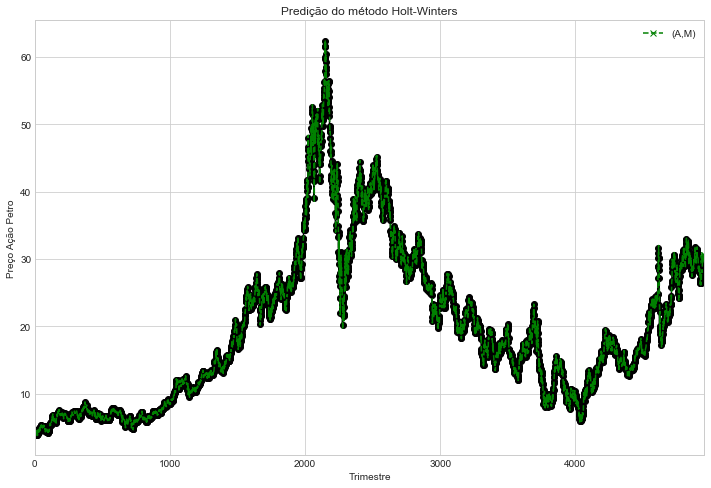

In [17]:
#Modeloa HW
dfPreco = pd.Series(data)


opt      = True  # To optimze
use_bc   = False # Box-Cox transformation (https://otexts.com/fpp2/transformations.html)
rem_bias = True

# (A,M)
fit_PRECO_HW = ExponentialSmoothing(dfPreco, seasonal_periods=4, trend='add', seasonal='mul').fit(optimized=opt,use_boxcox=use_bc,remove_bias=rem_bias)

# Resultados
results_PRECO_HW = pd.DataFrame(index=[r"$\alpha$",r"$\beta$",r"$\phi$",r"$\gamma$",r"$l_0$","$b_0$","SSE"])
params = ['smoothing_level', 'smoothing_slope', 'damping_slope', 'smoothing_seasonal', 'initial_level', 'initial_slope']
results_PRECO_HW["Multiplicativo (A,M)"] = [fit_PRECO_HW.params[p] for p in params] + [fit_PRECO_HW.sse]
results_PRECO_HW

ax = dfPreco.plot(figsize=(12,8), marker='o', color='black', title="Predição do método Holt-Winters" )
ax.set_ylabel("Preço Ação Petro")
ax.set_xlabel("Trimestre")

fit_PRECO_HW.fittedvalues.plot(ax=ax, style='--', color='green')

fit_PRECO_HW.forecast(12).rename('(A,M)').plot( ax=ax, style='--', marker='x', color='green',legend=True)

results_PRECO_HW

In [18]:
#Modeloa HW
dfPreco = data

opt      = True  # To optimze
use_bc   = False # Box-Cox transformation (https://otexts.com/fpp2/transformations.html)
rem_bias = True

# (A,M)
fit_PIB_HW = ExponentialSmoothing(dfPreco, seasonal_periods=4, trend='add', seasonal='mul').fit(optimized=opt,use_boxcox=use_bc,remove_bias=rem_bias)

# Resultados
#results_PIB_HW = pd.DataFrame(index=[r"$\alpha$",r"$\beta$",r"$\phi$",r"$\gamma$",r"$l_0$","$b_0$","SSE"])
#params = ['smoothing_level', 'smoothing_slope', 'damping_slope', 'smoothing_seasonal', 'initial_level', 'initial_slope']
#results_PIB_HW["Multiplicativo (A,M)"] = [fit_PIB_HW.params[p] for p in params] + [fit_PIB_HW.sse]
#results_PIB_HW

# Compara predição in-sample e 1 passo à frente do MLP e ETS - data original

i = 0
n_features=1
raw_seq=data
n_steps=3
predMLPo = list()
predHWo  = list()
predCNNo  = list()
predLSTMo  = list()
y_trueo  = list()
mlp_model=mlp(raw_seq,n_steps)
cnn_model=cnn(raw_seq,n_steps,n_features)
lstm_model=lstm(raw_seq,n_steps,n_features)
X, y = split_sequence(raw_seq, n_steps)
for v in X:
    PIB_ref = data[i+n_steps]  
    x_input = X[i] 
    x_input = x_input.reshape((1, n_steps))
    yhat_MLP = mlp_model.predict(x_input, verbose=0)[0][0]
    x_input_cnn = X[i].reshape((1, n_steps, n_features))
    yhat_CNN = cnn_model.predict(x_input_cnn, verbose=0)[0][0]
    x_input_lstm = X[i].reshape((1, n_steps, n_features))
    yhat_LSTM=lstm_model.predict(x_input_lstm, verbose=0)[0][0]
    yhat_HW = fit_PRECO_HW.fittedvalues[i+n_steps]
    predMLPo.append(yhat_MLP)
    predCNNo.append(yhat_CNN)
    predHWo.append(yhat_HW)
    predLSTMo.append(yhat_LSTM)
    y_trueo.append(PIB_ref)
    i = i + 1



    
    


(4941, 3) (4941,)


RMSE_HW  = 6.045189e-01
RMSE_MLP = 6.271741e-01
RMSE_CNN  = 6.643007e-01
RMSE_LSTM  = 7.667389e-01


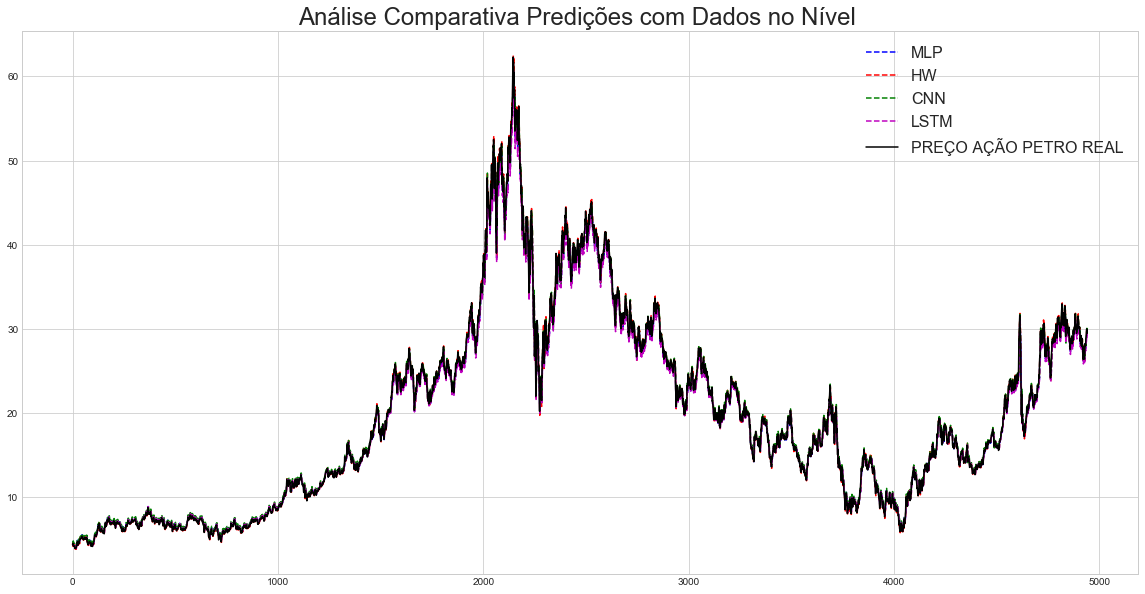

In [19]:
rmseMLPo = sqrt(mean_squared_error(y_trueo,predMLPo))
rmseHWo = sqrt(mean_squared_error(y_trueo,predHWo))
rmseCNNo = sqrt(mean_squared_error(y_trueo,predCNNo))
rmseLSTMo = sqrt(mean_squared_error(y_trueo,predLSTMo))
plt.figure(figsize=(20,10))

plt.plot(predMLPo,'--',color='b')
plt.plot(predHWo,'--',color='r')
plt.plot(predCNNo,'--',color='g')
plt.plot(predLSTMo,'--',color='m')
plt.plot(y_trueo,color='k')
plt.title("Análise Comparativa Predições com Dados no Nível ",fontsize=24);
plt.legend(['MLP','HW','CNN','LSTM','PREÇO AÇÃO PETRO REAL'],fontsize=16)


print('RMSE_HW  = %e' %(rmseHWo))
print('RMSE_MLP = %e' %(rmseMLPo))
print('RMSE_CNN  = %e' %(rmseCNNo))
print('RMSE_LSTM  = %e' %(rmseLSTMo))    

In [20]:
# Compara predição normalizada in-sample e 1 passo à frente do MLP e ETS - data original

i = 0
n_features=1
raw_seq=transformadon
n_steps=3
predMLPn = list()
predHWn  = list()
predCNNn  = list()
predLSTMn  = list()
y_truen  = list()
mlp_model=mlp(raw_seq,n_steps)
cnn_model=cnn(raw_seq,n_steps,n_features)
lstm_model=lstm(raw_seq,n_steps,n_features)
X, y = split_sequence(raw_seq, n_steps)
for v in X:
    PIB_ref = data[i+n_steps]  
    x_input = X[i] 
    x_input = x_input.reshape((1, n_steps))
    yhat_MLP = mlp_model.predict(x_input, verbose=0)[0][0]
    x_input_cnn = X[i].reshape((1, n_steps, n_features))
    yhat_CNN = cnn_model.predict(x_input_cnn, verbose=0)[0][0]
    x_input_lstm = X[i].reshape((1, n_steps, n_features))
    yhat_LSTM=lstm_model.predict(x_input_lstm, verbose=0)[0][0]
    yhat_HW = fit_PRECO_HW.fittedvalues[i+n_steps]
    predMLPn.append(yhat_MLP)
    predCNNn.append(yhat_CNN)
    predHWn.append(yhat_HW)
    predLSTMn.append(yhat_LSTM)
    y_truen.append(PIB_ref)
    i = i + 1


predMLPn=transformern.inverse_transform(np.array(predMLPn).reshape(-1, 1))
predCNNn=transformern.inverse_transform(np.array(predCNNn).reshape(-1, 1))
predLSTMn=transformern.inverse_transform(np.array(predLSTMn).reshape(-1, 1))

    

    
    


(4941, 3) (4941,)


RMSE_HW  = 6.045189e-01
RMSE_MLP = 6.146964e-01
RMSE_CNN  = 1.369409e+00
RMSE_LSTM  = 1.094960e+00


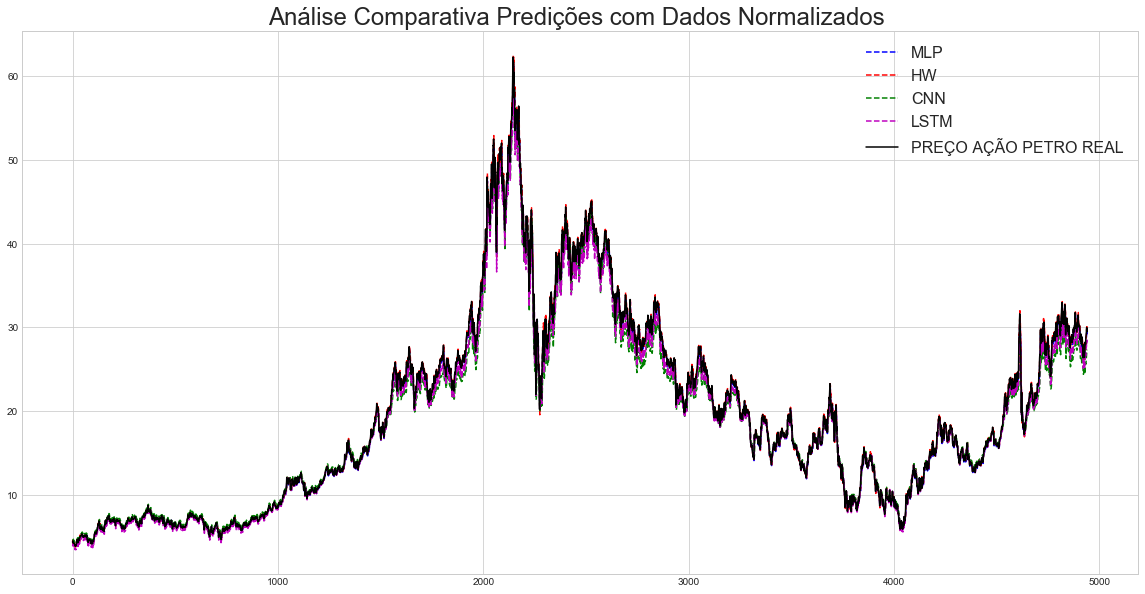

In [21]:
rmseMLPn = sqrt(mean_squared_error(y_truen,predMLPn))
rmseHWn = sqrt(mean_squared_error(y_truen,predHWn))
rmseCNNn = sqrt(mean_squared_error(y_truen,predCNNn))
rmseLSTMn = sqrt(mean_squared_error(y_truen,predLSTMn))
plt.figure(figsize=(20,10))

plt.plot(predMLPn,'--',color='b')
plt.plot(predHWn,'--',color='r')
plt.plot(predCNNn,'--',color='g')
plt.plot(predLSTMn,'--',color='m')
plt.plot(y_truen,color='k')
plt.title("Análise Comparativa Predições com Dados Normalizados ",fontsize=24);
plt.legend(['MLP','HW','CNN','LSTM','PREÇO AÇÃO PETRO REAL'],fontsize=16)



print('RMSE_HW  = %e' %(rmseHWn))
print('RMSE_MLP = %e' %(rmseMLPn))
print('RMSE_CNN  = %e' %(rmseCNNn))
print('RMSE_LSTM  = %e' %(rmseLSTMn))    

In [22]:
# Compara predição padronizada in-sample e 1 passo à frente do MLP e ETS - data original

i = 0
n_features=1
raw_seq=transformadop
n_steps=3
predMLPp = list()
predHWp  = list()
predCNNp  = list()
predLSTMp  = list()
y_truep  = list()
mlp_model=mlp(raw_seq,n_steps)
cnn_model=cnn(raw_seq,n_steps,n_features)
lstm_model=lstm(raw_seq,n_steps,n_features)
X, y = split_sequence(raw_seq, n_steps)
for v in X:
    PIB_ref = data[i+n_steps]  
    x_input = X[i] 
    x_input = x_input.reshape((1, n_steps))
    yhat_MLP = mlp_model.predict(x_input, verbose=0)[0][0]
    x_input_cnn = X[i].reshape((1, n_steps, n_features))
    yhat_CNN = cnn_model.predict(x_input_cnn, verbose=0)[0][0]
    x_input_lstm = X[i].reshape((1, n_steps, n_features))
    yhat_LSTM=lstm_model.predict(x_input_lstm, verbose=0)[0][0]
    yhat_HW = fit_PRECO_HW.fittedvalues[i+n_steps]
    predMLPp.append(yhat_MLP)
    predCNNp.append(yhat_CNN)
    predHWp.append(yhat_HW)
    predLSTMp.append(yhat_LSTM)
    y_truep.append(PIB_ref)
    i = i + 1


predMLPp=transformerp.inverse_transform(np.array(predMLPp).reshape(-1, 1))
predCNNp=transformerp.inverse_transform(np.array(predCNNp).reshape(-1, 1))
predLSTMp=transformerp.inverse_transform(np.array(predLSTMp).reshape(-1, 1))

    

    
    

(4941, 3) (4941,)


RMSE_HW  = 6.045189e-01
RMSE_MLP = 6.712243e-01
RMSE_CNN  = 1.850965e+00
RMSE_LSTM  = 7.828803e-01


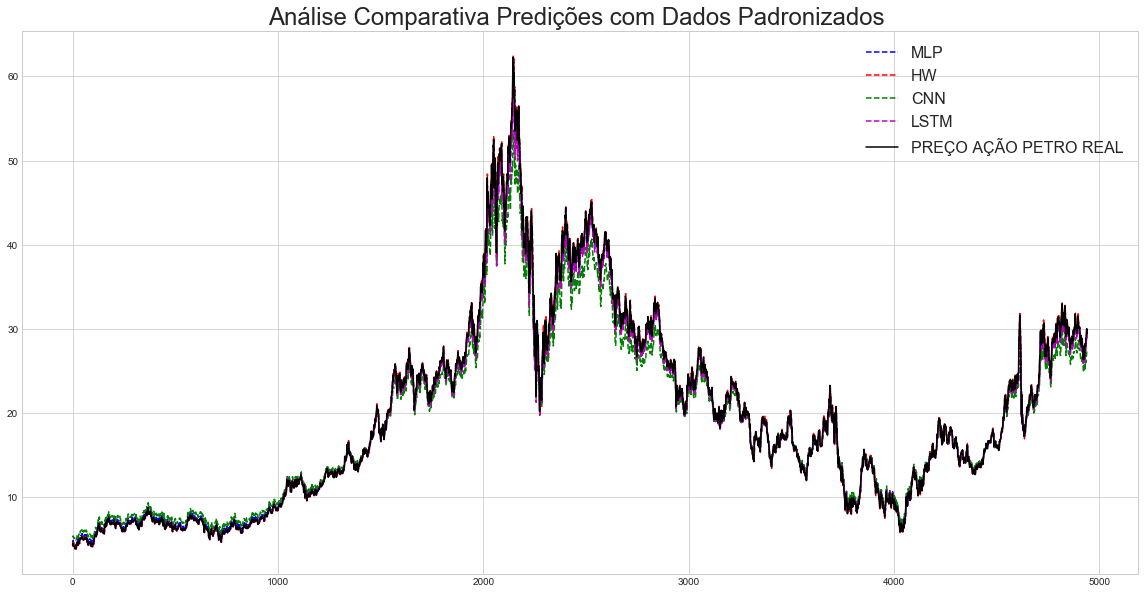

In [23]:
rmseMLPp = sqrt(mean_squared_error(y_truep,predMLPp))
rmseHWp = sqrt(mean_squared_error(y_truep,predHWp))
rmseCNNp = sqrt(mean_squared_error(y_truep,predCNNp))
rmseLSTMp = sqrt(mean_squared_error(y_truep,predLSTMp))
plt.figure(figsize=(20,10))

plt.plot(predMLPp,'--',color='b')
plt.plot(predHWp,'--',color='r')
plt.plot(predCNNp,'--',color='g')
plt.plot(predLSTMp,'--',color='m')
plt.plot(y_truep,color='k')
plt.title("Análise Comparativa Predições com Dados Padronizados ",fontsize=24);
plt.legend(['MLP','HW','CNN','LSTM','PREÇO AÇÃO PETRO REAL'],fontsize=16)



print('RMSE_HW  = %e' %(rmseHWp))
print('RMSE_MLP = %e' %(rmseMLPp))
print('RMSE_CNN  = %e' %(rmseCNNp))
print('RMSE_LSTM  = %e' %(rmseLSTMp))    

In [24]:
# Compara predição 1 diferenca e normalizada in-sample e 1 passo à frente do MLP e ETS - data original

i = 0
n_features=1
raw_seq=transformado1dn
n_steps=3
predMLP1dn = list()
predHW1dn  = list()
predCNN1dn  = list()
predLSTM1dn  = list()
y_true1dn  = list()
mlp_model=mlp(raw_seq,n_steps)
cnn_model=cnn(raw_seq,n_steps,n_features)
lstm_model=lstm(raw_seq,n_steps,n_features)
X, y = split_sequence(raw_seq, n_steps)
for v in X:
    PIB_ref = data[i+n_steps]  
    x_input = X[i] 
    x_input = x_input.reshape((1, n_steps))
    yhat_MLP = mlp_model.predict(x_input, verbose=0)[0][0]
    x_input_cnn = X[i].reshape((1, n_steps, n_features))
    yhat_CNN = cnn_model.predict(x_input_cnn, verbose=0)[0][0]
    x_input_lstm = X[i].reshape((1, n_steps, n_features))
    yhat_LSTM=lstm_model.predict(x_input_lstm, verbose=0)[0][0]
    yhat_HW = fit_PRECO_HW.fittedvalues[i+n_steps]
    predMLP1dn.append(yhat_MLP)
    predCNN1dn.append(yhat_CNN)
    predHW1dn.append(yhat_HW)
    predLSTM1dn.append(yhat_LSTM)
    y_true1dn.append(PIB_ref)
    i = i + 1



invertidoMLP1dn = transformer1dn.inverse_transform(np.array(predMLP1dn).reshape(-1, 1))
predMLP1dn=inverte_diferenca(data[n_steps:,],invertidoMLP1dn,1)


invertidoCNN1dn = transformer1dn.inverse_transform(np.array(predCNN1dn).reshape(-1, 1))
predCNN1dn=inverte_diferenca(data[n_steps:,],invertidoCNN1dn,1)


invertidoLSTM1dn = transformer1dn.inverse_transform(np.array(predLSTM1dn).reshape(-1, 1))
predLSTM1dn=inverte_diferenca(data[n_steps:,],invertidoLSTM1dn,1)
    

(4940, 3) (4940,)


RMSE_HW  = 6.045574e-01
RMSE_MLP = 3.984542e-02
RMSE_CNN  = 1.958961e-01
RMSE_LSTM  = 1.907987e-01


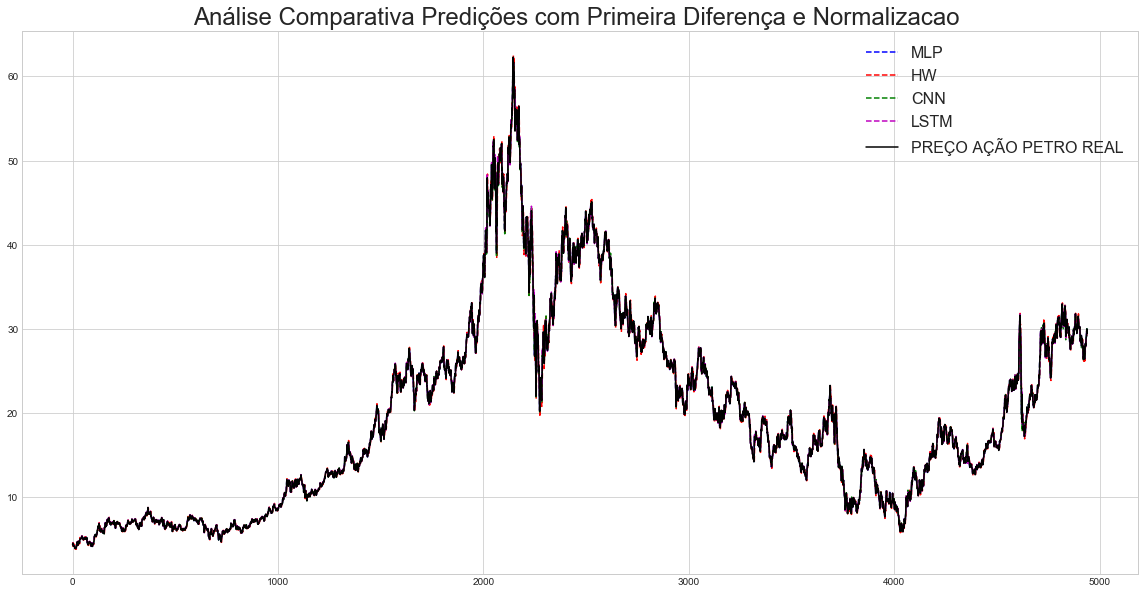

In [25]:
rmseMLP1dn = sqrt(mean_squared_error(y_true1dn,predMLP1dn))
rmseHW1dn= sqrt(mean_squared_error(y_true1dn,predHW1dn))
rmseCNN1dn = sqrt(mean_squared_error(y_true1dn,predCNN1dn))
rmseLSTM1dn = sqrt(mean_squared_error(y_true1dn,predLSTM1dn))
plt.figure(figsize=(20,10))

plt.plot(predMLP1dn,'--',color='b')
plt.plot(predHW1dn,'--',color='r')
plt.plot(predCNN1dn,'--',color='g')
plt.plot(predLSTM1dn,'--',color='m')
plt.plot(y_true1dn,color='k')
plt.title("Análise Comparativa Predições com Primeira Diferença e Normalizacao ",fontsize=24);
plt.legend(['MLP','HW','CNN','LSTM','PREÇO AÇÃO PETRO REAL'],fontsize=16)


print('RMSE_HW  = %e' %(rmseHW1dn))
print('RMSE_MLP = %e' %(rmseMLP1dn))
print('RMSE_CNN  = %e' %(rmseCNN1dn))
print('RMSE_LSTM  = %e' %(rmseLSTM1dn))  

In [26]:
# Compara predição 1 diferenca e padronizacao in-sample e 1 passo à frente do MLP e ETS - data original

i = 0
n_features=1
raw_seq=transformado1dp
n_steps=3
predMLP1dp = list()
predHW1dp  = list()
predCNN1dp  = list()
predLSTM1dp  = list()
y_true1dp  = list()
mlp_model=mlp(raw_seq,n_steps)
cnn_model=cnn(raw_seq,n_steps,n_features)
lstm_model=lstm(raw_seq,n_steps,n_features)
X, y = split_sequence(raw_seq, n_steps)
for v in X:
    PIB_ref = data[i+n_steps]  
    x_input = X[i] 
    x_input = x_input.reshape((1, n_steps))
    yhat_MLP = mlp_model.predict(x_input, verbose=0)[0][0]
    x_input_cnn = X[i].reshape((1, n_steps, n_features))
    yhat_CNN = cnn_model.predict(x_input_cnn, verbose=0)[0][0]
    x_input_lstm = X[i].reshape((1, n_steps, n_features))
    yhat_LSTM=lstm_model.predict(x_input_lstm, verbose=0)[0][0]
    yhat_HW = fit_PRECO_HW.fittedvalues[i+n_steps]
    predMLP1dp.append(yhat_MLP)
    predCNN1dp.append(yhat_CNN)
    predHW1dp.append(yhat_HW)
    predLSTM1dp.append(yhat_LSTM)
    y_true1dp.append(PIB_ref)
    i = i + 1



invertidoMLP1dp = transformer1dp.inverse_transform(np.array(predMLP1dp).reshape(-1, 1))
predMLP1dp=inverte_diferenca(data[n_steps:,],invertidoMLP1dp,1)


invertidoCNN1dp = transformer1dp.inverse_transform(np.array(predCNN1dp).reshape(-1, 1))
predCNN1dp=inverte_diferenca(data[n_steps:,],invertidoCNN1dp,1)


invertidoLSTM1dp = transformer1dp.inverse_transform(np.array(predLSTM1dp).reshape(-1, 1))
predLSTM1dp=inverte_diferenca(data[n_steps:,],invertidoLSTM1dp,1)
    

(4940, 3) (4940,)


RMSE_HW  = 6.045574e-01
RMSE_MLP = 4.059501e-02
RMSE_CNN  = 1.876910e-01
RMSE_LSTM  = 2.709338e-01


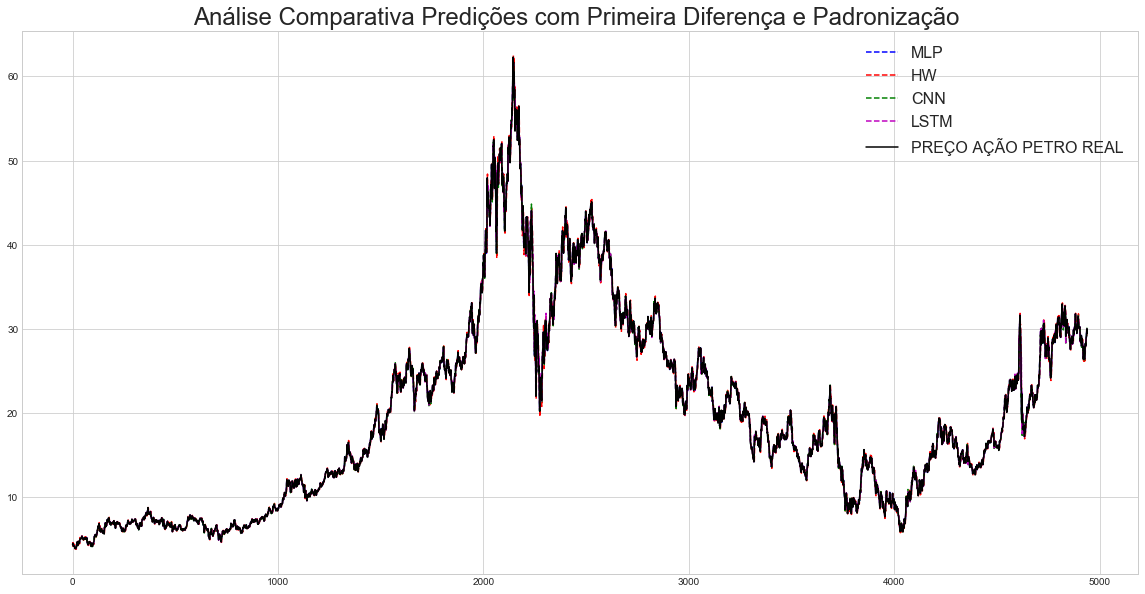

In [27]:
rmseMLP1dp = sqrt(mean_squared_error(y_true1dp,predMLP1dp))
rmseHW1dp= sqrt(mean_squared_error(y_true1dp,predHW1dp))
rmseCNN1dp = sqrt(mean_squared_error(y_true1dp,predCNN1dp))
rmseLSTM1dp = sqrt(mean_squared_error(y_true1dp,predLSTM1dp))
plt.figure(figsize=(20,10))

plt.plot(predMLP1dp,'--',color='b')
plt.plot(predHW1dp,'--',color='r')
plt.plot(predCNN1dp,'--',color='g')
plt.plot(predLSTM1dp,'--',color='m')
plt.plot(y_true1dp,color='k')
plt.title("Análise Comparativa Predições com Primeira Diferença e Padronização ",fontsize=24);
plt.legend(['MLP','HW','CNN','LSTM','PREÇO AÇÃO PETRO REAL'],fontsize=16)



print('RMSE_HW  = %e' %(rmseHW1dp))
print('RMSE_MLP = %e' %(rmseMLP1dp))
print('RMSE_CNN  = %e' %(rmseCNN1dp))
print('RMSE_LSTM  = %e' %(rmseLSTM1dp))  

In [28]:
#Compara predição 2 diferenca e normalização in-sample e 1 passo à frente do MLP e ETS - data original


i = 0
n_features=1
raw_seq=transformado2dn
n_steps=3
predMLP2dn = list()
predHW2dn  = list()
predCNN2dn  = list()
predLSTM2dn  = list()
y_true2dn  = list()
mlp_model=mlp(raw_seq,n_steps)
cnn_model=cnn(raw_seq,n_steps,n_features)
lstm_model=lstm(raw_seq,n_steps,n_features)
X, y = split_sequence(raw_seq, n_steps)
for v in X:
    PIB_ref = data[i+n_steps]  
    x_input = X[i] 
    x_input = x_input.reshape((1, n_steps))
    yhat_MLP = mlp_model.predict(x_input, verbose=0)[0][0]
    x_input_cnn = X[i].reshape((1, n_steps, n_features))
    yhat_CNN = cnn_model.predict(x_input_cnn, verbose=0)[0][0]
    x_input_lstm = X[i].reshape((1, n_steps, n_features))
    yhat_LSTM=lstm_model.predict(x_input_lstm, verbose=0)[0][0]
    yhat_HW = fit_PRECO_HW.fittedvalues[i+n_steps]
    predMLP2dn.append(yhat_MLP)
    predCNN2dn.append(yhat_CNN)
    predHW2dn.append(yhat_HW)
    predLSTM2dn.append(yhat_LSTM)
    y_true2dn.append(PIB_ref)
    i = i + 1


invertidoMLP2dn = transformer2dn.inverse_transform(np.array(predMLP2dn).reshape(-1, 1))
predMLP2dn=inverte_diferenca(diff_data4[n_steps:],invertidoMLP2dn,1)
predMLP2dn=inverte_diferenca(data[n_steps+1:,],predMLP2dn,4)

invertidoCNN2dn = transformer2dn.inverse_transform(np.array(predCNN2dn).reshape(-1, 1))
predCNN2dn=inverte_diferenca(diff_data4[n_steps:],invertidoCNN2dn,1)
predCNN2dn=inverte_diferenca(data[n_steps+1:,],predCNN2dn,4)


invertidoLSTM2dn = transformer2dn.inverse_transform(np.array(predLSTM2dn).reshape(-1, 1))
predLSTM2dn=inverte_diferenca(diff_data4[n_steps:],invertidoLSTM2dn,1)
predLSTM2dn=inverte_diferenca(data[n_steps+1:,],predLSTM2dn,4)

(4936, 3) (4936,)


RMSE_MLP = 1.523803e+00
RMSE_CNN  = 1.475951e+00
RMSE_LSTM  = 1.496006e+00
RMSE_HW  = 6.046772e-01


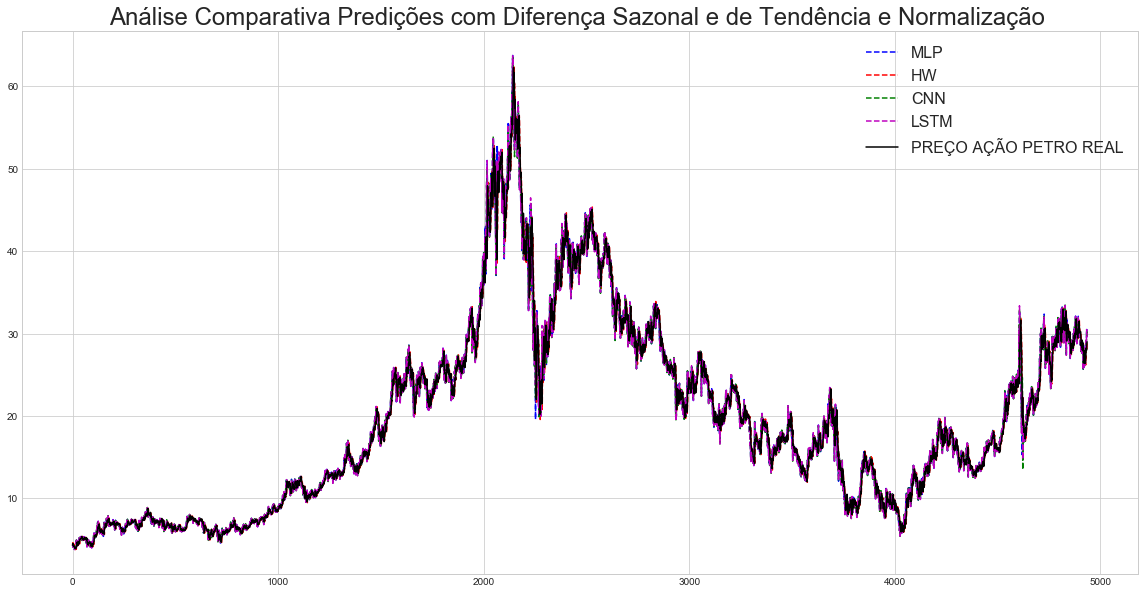

In [29]:
rmseMLP2dn = sqrt(mean_squared_error(y_true2dn,predMLP2dn))
rmseHW2dn = sqrt(mean_squared_error(y_true2dn,predHW2dn))
rmseCNN2dn = sqrt(mean_squared_error(y_true2dn,predCNN2dn))
rmseLSTM2dn = sqrt(mean_squared_error(y_true2dn,predLSTM2dn))
plt.figure(figsize=(20,10))

plt.plot(predMLP2dn,'--',color='b')
plt.plot(predHW2dn,'--',color='r')
plt.plot(predCNN2dn,'--',color='g')
plt.plot(predLSTM2dn,'--',color='m')
plt.plot(y_true2dn,color='k')
plt.title("Análise Comparativa Predições com Diferença Sazonal e de Tendência e Normalização ",fontsize=24);
plt.legend(['MLP','HW','CNN','LSTM','PREÇO AÇÃO PETRO REAL'],fontsize=16)


print('RMSE_MLP = %e' %(rmseMLP2dn))
print('RMSE_CNN  = %e' %(rmseCNN2dn))
print('RMSE_LSTM  = %e' %(rmseLSTM2dn))
print('RMSE_HW  = %e' %(rmseHW2dn))

In [30]:
#Compara predição 2 diferenca e normalização in-sample e 1 passo à frente do MLP e ETS - data original


i = 0
n_features=1
raw_seq=transformado2dp
n_steps=3
predMLP2dp = list()
predHW2dp  = list()
predCNN2dp  = list()
predLSTM2dp  = list()
y_true2dp  = list()
mlp_model=mlp(raw_seq,n_steps)
cnn_model=cnn(raw_seq,n_steps,n_features)
lstm_model=lstm(raw_seq,n_steps,n_features)
X, y = split_sequence(raw_seq, n_steps)
for v in X:
    PIB_ref = data[i+n_steps]  
    x_input = X[i] 
    x_input = x_input.reshape((1, n_steps))
    yhat_MLP = mlp_model.predict(x_input, verbose=0)[0][0]
    x_input_cnn = X[i].reshape((1, n_steps, n_features))
    yhat_CNN = cnn_model.predict(x_input_cnn, verbose=0)[0][0]
    x_input_lstm = X[i].reshape((1, n_steps, n_features))
    yhat_LSTM=lstm_model.predict(x_input_lstm, verbose=0)[0][0]
    yhat_HW = fit_PRECO_HW.fittedvalues[i+n_steps]
    predMLP2dp.append(yhat_MLP)
    predCNN2dp.append(yhat_CNN)
    predHW2dp.append(yhat_HW)
    predLSTM2dp.append(yhat_LSTM)
    y_true2dp.append(PIB_ref)
    i = i + 1


invertidoMLP2dp = transformer2dp.inverse_transform(np.array(predMLP2dp).reshape(-1, 1))
predMLP2dp=inverte_diferenca(diff_data4[n_steps:],invertidoMLP2dp,1)
predMLP2dp=inverte_diferenca(data[n_steps+1:,],predMLP2dp,4)

invertidoCNN2dp = transformer2dp.inverse_transform(np.array(predCNN2dp).reshape(-1, 1))
predCNN2dp=inverte_diferenca(diff_data4[n_steps:],invertidoCNN2dp,1)
predCNN2dp=inverte_diferenca(data[n_steps+1:,],predCNN2dp,4)


invertidoLSTM2dp = transformer2dp.inverse_transform(np.array(predLSTM2dp).reshape(-1, 1))
predLSTM2dp=inverte_diferenca(diff_data4[n_steps:],invertidoLSTM2dp,1)
predLSTM2dp=inverte_diferenca(data[n_steps+1:,],predLSTM2dp,4)

(4936, 3) (4936,)


RMSE_MLP = 1.523813e+00
RMSE_CNN  = 1.468807e+00
RMSE_LSTM  = 1.490620e+00
RMSE_HW  = 6.046772e-01


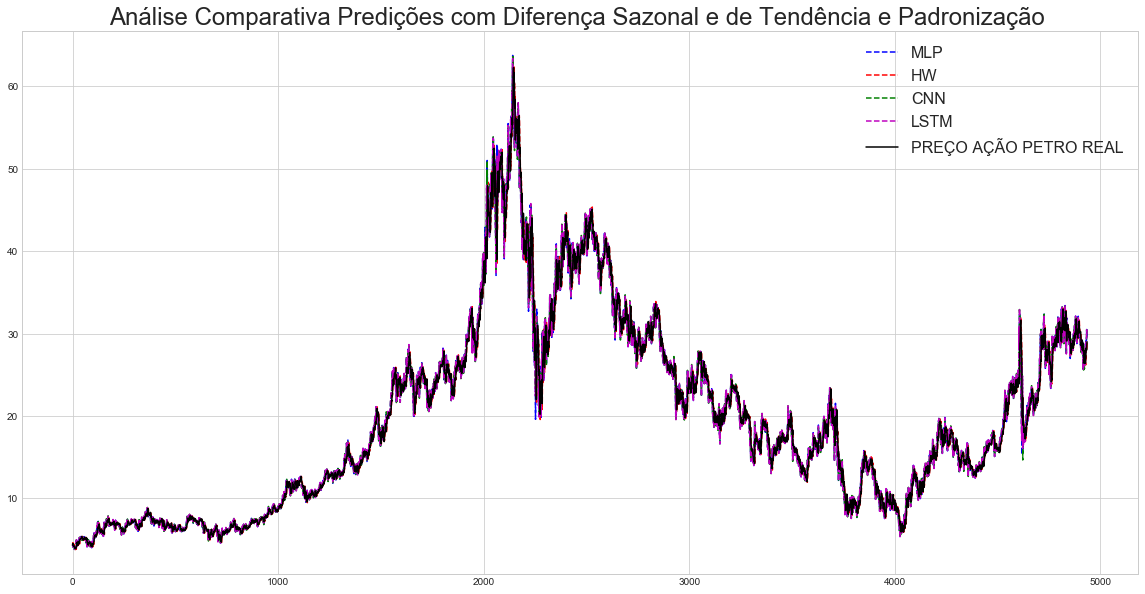

In [31]:
rmseMLP2dp = sqrt(mean_squared_error(y_true2dp,predMLP2dp))
rmseHW2dp = sqrt(mean_squared_error(y_true2dp,predHW2dp))
rmseCNN2dp = sqrt(mean_squared_error(y_true2dp,predCNN2dp))
rmseLSTM2dp = sqrt(mean_squared_error(y_true2dp,predLSTM2dp))
plt.figure(figsize=(20,10))

plt.plot(predMLP2dp,'--',color='b')
plt.plot(predHW2dp,'--',color='r')
plt.plot(predCNN2dp,'--',color='g')
plt.plot(predLSTM2dp,'--',color='m')
plt.plot(y_true2dp,color='k')
plt.title("Análise Comparativa Predições com Diferença Sazonal e de Tendência e Padronização ",fontsize=24);
plt.legend(['MLP','HW','CNN','LSTM','PREÇO AÇÃO PETRO REAL'],fontsize=16)


print('RMSE_MLP = %e' %(rmseMLP2dp))
print('RMSE_CNN  = %e' %(rmseCNN2dp))
print('RMSE_LSTM  = %e' %(rmseLSTM2dp))
print('RMSE_HW  = %e' %(rmseHW2dp))

In [32]:
resultados = pd.DataFrame(index=['HW','MLP','CNN','LSTM'],columns=['NÍVEL','NORM.','PADRONIZADO','1DIF E NORM.','1DIF E PADR.','2DIF E NORM.'])
resultados.loc['HW','NÍVEL']=rmseHWo
resultados.loc['MLP','NÍVEL']=rmseMLPo
resultados.loc['CNN','NÍVEL']=rmseCNNo
resultados.loc['LSTM','NÍVEL']=rmseLSTMo
#resultados.loc['HW','NORM.']=
resultados.loc['MLP','NORM.']=rmseMLPn
resultados.loc['CNN','NORM.']=rmseCNNn
resultados.loc['LSTM','NORM.']=rmseLSTMn
#resultados.loc['HW','PADRONIZADO']=rmseHWp
resultados.loc['MLP','PADRONIZADO']=rmseMLPp
resultados.loc['CNN','PADRONIZADO']=rmseCNNp
resultados.loc['LSTM','PADRONIZADO']=rmseLSTMp
#resultados.loc['HW','1DIF E NORM.']=rmseHW1dn
resultados.loc['MLP','1DIF E NORM.']=rmseMLP1dn
resultados.loc['CNN','1DIF E NORM.']=rmseCNN1dn
resultados.loc['LSTM','1DIF E NORM.']=rmseLSTM1dn
#resultados.loc['HW','1DIF E PADR.']=rmseHW1dp
resultados.loc['MLP','1DIF E PADR.']=rmseMLP1dp
resultados.loc['CNN','1DIF E PADR.']=rmseCNN1dp
resultados.loc['LSTM','1DIF E PADR.']=rmseLSTM1dp
#resultados.loc['HW','2DIF E NORM.']=rmseHW2dn
resultados.loc['MLP','2DIF E NORM.']=rmseMLP2dn
resultados.loc['CNN','2DIF E NORM.']=rmseCNN2dn
resultados.loc['LSTM','2DIF E NORM.']=rmseLSTM2dn
#resultados.loc['HW','2DIF E PADR.']=rmseHW2dp
resultados.loc['MLP','2DIF E PADR.']=rmseMLP2dp
resultados.loc['CNN','2DIF E PADR.']=rmseCNN2dp
resultados.loc['LSTM','2DIF E PADR.']=rmseLSTM2dp

In [33]:
def highlight_min(s):    
    is_max = s == s.min()
    return ['background-color: yellow' if v else '' for v in is_max]
 
print ('\033[1m' + 'Melhores resultados por Transformação' + '\033[0m')
resultados.style.apply(highlight_min)

Melhores resultados por Transformação


,NÍVEL,NORM.,PADRONIZADO,1DIF E NORM.,1DIF E PADR.,2DIF E NORM.,2DIF E PADR.
HW,0.604519,nan,nan,nan,nan,nan,nan
MLP,0.627174,0.614696,0.671224,0.0398454,0.040595,1.5238,1.52381
CNN,0.664301,1.36941,1.85097,0.195896,0.187691,1.47595,1.46881
LSTM,0.766739,1.09496,0.78288,0.190799,0.270934,1.49601,1.49062


In [34]:
print ('\033[1m' + 'Melhores resultados por Método' + '\033[0m')
resultados.style.apply(highlight_min, axis=1)

Melhores resultados por Método


,NÍVEL,NORM.,PADRONIZADO,1DIF E NORM.,1DIF E PADR.,2DIF E NORM.,2DIF E PADR.
HW,0.604519,nan,nan,nan,nan,nan,nan
MLP,0.627174,0.614696,0.671224,0.0398454,0.040595,1.5238,1.52381
CNN,0.664301,1.36941,1.85097,0.195896,0.187691,1.47595,1.46881
LSTM,0.766739,1.09496,0.78288,0.190799,0.270934,1.49601,1.49062


In [35]:
print ('\033[1m' + 'Melhores resultado Geral' + '\033[0m')
resultados.min().min()

Melhores resultado Geral


0.03984542466812306

Com base nas duas tabelas acima, é possível constatar, primeiramente, que o método com a melhor precisão, isto é, com melhor RMSE, foi o método MLP com as transformações de primeira diferença e normalização. Importante destacar que não foram plicadas as transformações para o método clássico HW, por isto os valores estão preenchidos como nan.

A transformação que mais contribuiu para o alcance de resultados superiores para todos os métodos de inteligência computacional foi a primeira diferença atrelada à normalização ou a padronização. A realização somente da normalização ou a da padronização, por outro lado, levou a resultados de previsão inferiores, inclusive quando comparamos com a previsão com o dado original no nível. Adicionalmente, a realização da transformação da segunda diferença, com o intuito de eliminar a sazonalidade, levou a resultados de RMSE piores do que ao obtido somente com a primeira diferença, que elimina a tendência.  

O  modelo MLP foi o apresentou melhores resultados na maior parte dos casos, com exceção dos casos onde foi aplicado o tratamento da segunda diferença para eliminar a sazonalidade, em que a rede CNN foi foi melhor quando foi aplicada a transformação de 2 diferenças com normalização e padronização. No nível, a o modelo clássico entregou resultados melhores.

Por fim, analisando do ponto de vista de cada técnica, a melhor transformação com o objetivo de minimização do RMSE, para a MLP e para a LSTM o recomendado é realizar a primeira diferença e, posteriomente a normalização. Já para a CNN, o recomendado é realizar a primeira diferença com a padronização.